# Set up a simple thermal model
This thermal model has three stages, representing a cryostat with a fixed outer shell temperature near room temp, and a fixed inner temperature, representing a fixed thermal bath.

Available materials:
Loaded materials: ['Al6061', 'CuRRR100', 'CuRRR150', 'CuRRR50', 'G10norm', 'manganin', 'Kapton', 'G10warp', 'table_example', 'SS304L']
Middle Stage Support length = 0.033 m, Area = 4.032e-05 m²
length = 3.031088913245535 in
Inner Stage Support length = 0.077 m, Area = 4.032e-05 m²
Radiation: Middle -> Inner
	Plate area: 0.039 m²
	Wall area: 0.180 m²
	Total surface area: 0.257 m²
	Power: 1.21e+00 W
middle_shell_height = 14.0 in
Radiation: Outer -> Middle
	Plate area: 0.059 m²
	Wall area: 0.305 m²
	Total surface area: 0.422 m²
	Power: 7.59e+00 W
Inner Shell: Height = 10.125 in, Width = 8.75 in
Middle Shell: Height = 14.0 in, Width = 10.750000000000002 in
IDIOT CHECKS:
	CONDUCTION:
		ConInt G10warp from 295 -> 252.01 K: 35.949 W/K
		ConInt G10warp from 252.01 -> 80 K: 103.287 W/K
		Outer -> Middle Strap Heat Flow: 295 -> 252.01 K: 0.044 W/K
		Middle -> Inner Strap Heat Flow: 252.01 -> 80 K: 0.054 W/K
		Outer -> Middle Conduction Total Power: 295 -> 252.01 K: 0.351 W
	

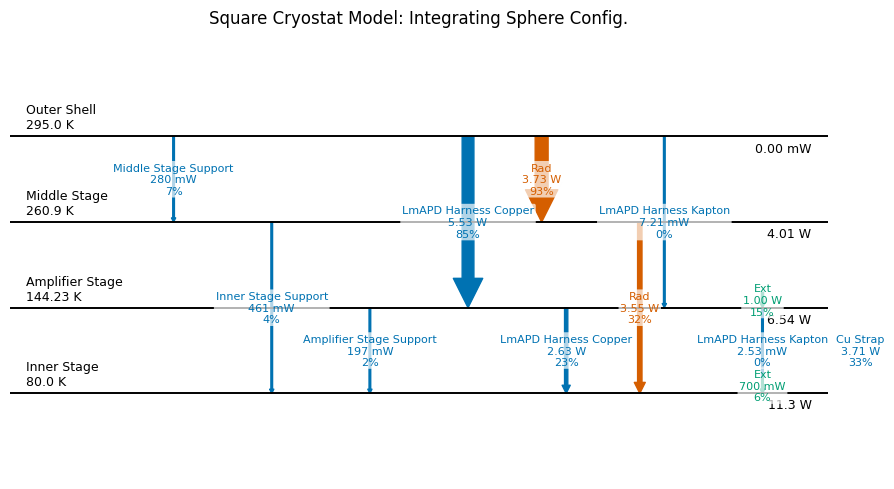

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import astropy.units as u

from cryotherm import DATA_PATH                      # packaged resource
from cryotherm.material_db import MaterialDatabase
from cryotherm.stage import Stage
from cryotherm.conduction import Conduction
from cryotherm.radiation import Radiation, WindowRadiation
from cryotherm.solver import ThermalModel
from cryotherm.visualize import visualize_model   # or paste the code block once


in_to_m = 0.0254  # conversion factor from inches to metres


# ---------------------------------------------------------------------
# Material DB
# ---------------------------------------------------------------------
db = MaterialDatabase(DATA_PATH)

# list available materials
print("Available materials:")
db.report()



# ---------------------------------------------------------------------
#  Stages
# ---------------------------------------------------------------------
outer_shell_temp = 295  # K
middle_stage_temp = 200  # K
inner_stage_temp = 80  # K
amplifier_stage_temp = 150  # K

outer = Stage("Outer Shell", outer_shell_temp, fixed=True)
middle = Stage("Middle Stage", middle_stage_temp, fixed=False)
use_fridge = False
if use_fridge:
    inner = Stage("Inner Stage", inner_stage_temp, fridge_curve="CryotelGT", fixed=False)
else:
    inner = Stage("Inner Stage", inner_stage_temp, fixed=True, external_load = 0.7)

amplifier_stage = Stage("Amplifier Stage", amplifier_stage_temp, external_load = 1.0, fixed=False,
                        #target_temperature=amplifier_stage_temp,
                        )

# ---------------------------------------------------------------------
#  Conduction
# ---------------------------------------------------------------------
standoff_material = "G10warp"  # material of the support cylinder
# Middle Stage Support
support_angle = 60  # degrees between supports
height_above_base = 1.125*in_to_m # height in metres\
length = height_above_base/np.sin(np.radians(support_angle)) # height in metres
width = 0.5*in_to_m # width in metres
thickness = 0.125*in_to_m # thickness in metres
number = 8  # number of support rods
# set up the support using the geometric methods
middle_stage_mech_support = Conduction(outer, middle, type = "rect", width=width, thickness=thickness,
                                length=length, number=number, 
                                material=standoff_material, mat_db=db, method = "legacy",
                                name="Middle Stage Support")
print(f"Middle Stage Support length = {middle_stage_mech_support.length:.3f} m, Area = {middle_stage_mech_support.area:.3e} m²")


# Inner Stage Support



height_between_stages = 2.625*in_to_m # height in metres


support_angle = 60  # degrees between supports
length = height_between_stages/np.sin(np.radians(support_angle)) # height in metres
print(f"length = {length/in_to_m} in")
width = 0.5*in_to_m # width in metres
thickness = 0.125*in_to_m # thickness in metres
number = 8  # number of support rods
# set up the support using the geometric methods
inner_stage_mech_support = Conduction(middle, inner, type = "rect", width=width, thickness=thickness,
                                length=length, number=number, 
                                material=standoff_material, mat_db=db, method = "legacy",
                                name="Inner Stage Support")

print(f"Inner Stage Support length = {inner_stage_mech_support.length:.3f} m, Area = {inner_stage_mech_support.area:.3e} m²")

# Support for Amplifier Stage
amplifier_stage_height_above_base = 1.0*in_to_m # height in metres\
amplifier_stage_length = amplifier_stage_height_above_base
amplifier_stage_width = 0.5*in_to_m # width in metres
amplifier_stage_thickness = 0.125*in_to_m # thickness in metres
amplifier_stage_number = 4  # number of support rods
# set up the support using the geometric methods
amplifier_stage_mech_support = Conduction(inner, amplifier_stage, type = "rect", 
                                          width=amplifier_stage_width, thickness=amplifier_stage_thickness,
                                          length = amplifier_stage_length, number=amplifier_stage_number, 
                                          material=standoff_material, mat_db=db, method = "legacy",
                                          name="Amplifier Stage Support")

# ---------------------------------------------------------------------
# Radiation
# ---------------------------------------------------------------------

# Radiation: Middle -> Inner
inner_shell_diameter = 8.75*in_to_m # outer diameter in metres
inner_shell_height = 10.125*in_to_m # height in metres
area_plate = inner_shell_diameter**2 / 4 * np.pi  # area of the top plate
area_wall = np.pi * inner_shell_diameter * inner_shell_height  # area of the cylindrical wall
total_surface_area = area_wall + 2*area_plate  # total surface area of the outer shell
emissivity_outer = 0.08
emissivity_inner = 0.08

#radiation_middle_to_inner = Radiation(middle, inner, type = "cylinder", diameter = diameter, height = height, emissivity1=emissivity_outer, emissivity2=emissivity_inner,
#                                      name = None)
radiation_middle_to_inner = Radiation(middle, inner, type = "box", length = inner_shell_diameter, width = inner_shell_diameter, height = inner_shell_height, 
                                      emissivity1=emissivity_outer, emissivity2=emissivity_inner,
                                      name = None)
print("Radiation: Middle -> Inner")
print(f"\tPlate area: {area_plate:.3f} m²")
print(f"\tWall area: {area_wall:.3f} m²")
print(f"\tTotal surface area: {total_surface_area:.3f} m²")
print(f"\tPower: {radiation_middle_to_inner.heat_flow(middle_stage_temp, inner_stage_temp):.2e} W")


# Radiation: Outer -> Middle
middle_shell_diameter = 10.75*in_to_m # outer diameter
middle_shell_height = 14.0*in_to_m # height in metres
print(f"middle_shell_height = {middle_shell_height/in_to_m} in")
area_plate = middle_shell_diameter**2 / 4 * np.pi  # area of the top plate
area_wall = np.pi * middle_shell_diameter * middle_shell_height  # area of the cylindrical wall

total_surface_area = area_wall + 2*area_plate  # total surface area of the outer shell
# Emissivity values for the outer and inner surfaces
emissivity_outer = 0.08
emissivity_inner = 0.08

#radiation_outer_to_middle = Radiation(outer, middle, type = "cylinder", diameter = diameter, 
#                                      height = height, 
#                                      emissivity1=emissivity_outer, emissivity2=emissivity_inner,
#                                      name= None)
radiation_outer_to_middle = Radiation(outer, middle, type = "box", 
                                      length = middle_shell_diameter, width = middle_shell_diameter, height = middle_shell_height, 
                                      emissivity1=emissivity_outer, emissivity2=emissivity_inner,
                                      name= None)
print("Radiation: Outer -> Middle")
print(f"\tPlate area: {area_plate:.3f} m²")
print(f"\tWall area: {area_wall:.3f} m²")
print(f"\tTotal surface area: {total_surface_area:.3f} m²")
print(f"\tPower: {radiation_outer_to_middle.heat_flow(outer_shell_temp, middle_stage_temp):.2e} W")

print(f"Inner Shell: Height = {inner_shell_height/in_to_m} in, Width = {inner_shell_diameter/in_to_m} in")
print(f"Middle Shell: Height = {middle_shell_height/in_to_m} in, Width = {middle_shell_diameter/in_to_m} in")

# ---------------------------------------------------------------------
# IDIOT CHECKS AGAINST EXCEL MODEL
# ---------------------------------------------------------------------
outer_stage_check_temp = 295  # K
middle_stage_check_temp = 252.01 # K
inner_stage_check_temp = 80  # K
print("IDIOT CHECKS:")
print("\tCONDUCTION:")
print(f"\t\tConInt {standoff_material} from {outer_stage_check_temp} -> {middle_stage_check_temp} K: {db.get_integral(standoff_material, T1 = outer_stage_check_temp, T2 = middle_stage_check_temp, method='legacy'):.3f} W/K")
print(f"\t\tConInt {standoff_material} from {middle_stage_check_temp} -> {inner_stage_check_temp} K: {db.get_integral(standoff_material, T1 = middle_stage_check_temp, T2 = inner_stage_check_temp, method='legacy'):.3f} W/K")
print(f"\t\tOuter -> Middle Strap Heat Flow: {outer_stage_check_temp} -> {middle_stage_check_temp} K: {middle_stage_mech_support._strap_heat(outer_stage_check_temp, middle_stage_check_temp):.3f} W/K")
print(f"\t\tMiddle -> Inner Strap Heat Flow: {middle_stage_check_temp} -> {inner_stage_check_temp} K: {inner_stage_mech_support._strap_heat(middle_stage_check_temp, inner_stage_check_temp):.3f} W/K")
print(f"\t\tOuter -> Middle Conduction Total Power: {outer_stage_check_temp} -> {middle_stage_check_temp} K: {middle_stage_mech_support.heat_flow(outer_stage_check_temp, middle_stage_check_temp):.3f} W")
print(f"\t\tMiddle -> Inner Conduction Total Power: {middle_stage_check_temp} -> {inner_stage_check_temp} K: {inner_stage_mech_support.heat_flow(middle_stage_check_temp, inner_stage_check_temp):.3f} W")

print("\tRADIATION:")
print(f"\t\tOuter -> Middle Radiation: Area = {radiation_outer_to_middle.area:.3f} m²")
print(f"\t\tMiddle -> Inner Radiation: Area = {radiation_middle_to_inner.area:.3f} m²")
print(f"\t\tOuter -> Middle Radiation Power: {outer_stage_check_temp} -> {middle_stage_check_temp} K: {radiation_outer_to_middle.heat_flow(outer_stage_check_temp, middle_stage_check_temp):.3f} W")
print(f"\t\tMiddle -> Inner Radiation Power: {middle_stage_check_temp} -> {inner_stage_check_temp} K: {radiation_middle_to_inner.heat_flow(middle_stage_check_temp, inner_stage_check_temp):.3f} W")

print("\tTOTALS")
print(f"\t\tOuter -> Middle Total Power: {middle_stage_mech_support.heat_flow(outer_stage_check_temp, middle_stage_check_temp) + radiation_outer_to_middle.heat_flow(outer_stage_check_temp, middle_stage_check_temp):.3f} W")
print(f"\t\tMiddle -> Inner Total Power: {inner_stage_mech_support.heat_flow(middle_stage_check_temp, inner_stage_check_temp) + radiation_middle_to_inner.heat_flow(middle_stage_check_temp, inner_stage_check_temp):.3f} W")

# ---------------------------------------------------------------------
# WIRING HARNESSES
# ---------------------------------------------------------------------

# 4k x 6k harness
#   dimensions: 100+69 wires, 36 AWG, 0.127 mm dia, manganin
length_harness = 12*in_to_m  # length in metres
number_wires = 169  # number of wires
wire_diameter = 0.127e-3  # diameter in metres
wire_material = "manganin"
harness_4k6k = Conduction(outer, inner, type = "cylinder", diameter=wire_diameter, length=length_harness,
                          number=number_wires, material=wire_material, mat_db=db, method = "legacy",
                          name="4k x 6k Harness")
print(f"4k x 6k Harness length = {harness_4k6k.length:.3f} m, Area = {harness_4k6k.area:.3e} m²")
print(f"\tConInt {wire_material} from {middle_stage_temp} -> {inner_stage_temp} K: {db.get_integral(wire_material, T1 = middle_stage_temp, T2 = inner_stage_temp, method='legacy'):.3f} W/K")
print(f"\t4k x 6k Harness Strap Heat Flow: {middle_stage_temp} -> {inner_stage_temp} K: {harness_4k6k._strap_heat(middle_stage_temp, inner_stage_temp):.3f} W/K")

# LmAPD harness
#   dimensions: 20 wires, 36 AWG, 0.127 mm dia, manganin
lmapd_harness_length = 6*in_to_m  # length in metres
lmapd_harness_layers = 6 # number of layers
lmapd_harness_copper_thickness = 30e-6  # 1 oz copper ~> 30 um thickness of copper layer in metres
lmapd_harness_width = 3 *in_to_m  # width in metres
lmapd_harness_material = "CuRRR100"
harness_lmapd = Conduction(outer, amplifier_stage, type = "rect", 
                           length=lmapd_harness_length, width=lmapd_harness_width,thickness=lmapd_harness_copper_thickness,
                           material = lmapd_harness_material, mat_db = db, number=lmapd_harness_layers, method = "legacy",
                           name = "LmAPD Harness Copper")

#harness from amplifier stage to LmAPD
harness_lmapd_fpa = Conduction(amplifier_stage, inner, type = "rect", 
                           length=lmapd_harness_length, width=lmapd_harness_width,thickness=lmapd_harness_copper_thickness,
                           material = lmapd_harness_material, mat_db = db, number=lmapd_harness_layers, method = "legacy",
                           name = "LmAPD Harness Copper")


lmapd_harness_kapton = Conduction(outer, amplifier_stage, type = "rect", 
                           length=lmapd_harness_length, 
                           width=lmapd_harness_width,
                           thickness=7.62e-5,# 3 mil kapton thickness
                           material = "Kapton", 
                           mat_db = db, 
                           number=int(lmapd_harness_layers+1), 
                           method = "legacy",
                           name = "LmAPD Harness Kapton")

lmapd_harness_kapton_fpa = Conduction(amplifier_stage, inner, type = "rect", 
                           length=lmapd_harness_length, 
                           width=lmapd_harness_width,
                           thickness=7.62e-5,# 3 mil kapton thickness
                           material = "Kapton", 
                           mat_db = db, 
                           number=int(lmapd_harness_layers+1), 
                           method = "legacy",
                           name = "LmAPD Harness Kapton")

loose_heat_strap_amp_to_inner = Conduction(amplifier_stage, inner, type = "rect", 
                                           thickness=0.02*in_to_m, length=4*in_to_m, width=1*in_to_m,
                                            number=1, material="CuRRR100", mat_db=db, method = "legacy",
                                            name = "Cu Strap")

loose_heat_strap_middle_to_amp = Conduction(middle, amplifier_stage, type = "rect", 
                                           thickness=0.02*in_to_m, length=4*in_to_m, width=0.5*in_to_m,
                                            number=1, material="CuRRR100", mat_db=db, method = "legacy",
                                            name = "Cu Strap")

# ---------------------------------------------------------------------
#  Cryostat Window
# ---------------------------------------------------------------------

                                     
# ---------------------------------------------------------------------
#  Solve
# ---------------------------------------------------------------------
model = ThermalModel(
    stages=[outer, middle, inner,
            amplifier_stage,
            ],
    conductors=[
        middle_stage_mech_support, 
        inner_stage_mech_support, 
        amplifier_stage_mech_support,
        #harness_4k6k,
        harness_lmapd,
        harness_lmapd_fpa,
        lmapd_harness_kapton,
        lmapd_harness_kapton_fpa,
        loose_heat_strap_amp_to_inner,
        #loose_heat_strap_middle_to_amp,
        ],
    radiators=[radiation_outer_to_middle, 
               radiation_middle_to_inner,
               ],
)

model.solve()                     # raises if the optimizer fails

for s in model.stages:
    print(f"{s.name:15s}:  {s.temperature:6.2f} K   netQ={s.net_heat_flow:+8.4f} W")

visualize_model(model, scale = 50, title = "Square Cryostat Model: Integrating Sphere Config.")

model.report()


Available materials:
Loaded materials: ['Al6061', 'CuRRR100', 'CuRRR150', 'CuRRR50', 'G10norm', 'manganin', 'Kapton', 'G10warp', 'table_example', 'SS304L']
Middle Stage Support length = 0.033 m, Area = 4.032e-05 m²
length = 3.031088913245535 in
Inner Stage Support length = 0.077 m, Area = 4.032e-05 m²
Radiation: Middle -> Inner
	Plate area: 0.039 m²
	Wall area: 0.053 m²
	Total surface area: 0.131 m²
	Power: 6.13e-01 W
middle_shell_height = 6.875 in
Radiation: Outer -> Middle
	Plate area: 0.059 m²
	Wall area: 0.150 m²
	Total surface area: 0.267 m²
	Power: 4.80e+00 W
Inner Shell: Height = 2.9999999999999996 in, Width = 8.75 in
Middle Shell: Height = 6.875 in, Width = 10.750000000000002 in
IDIOT CHECKS:
	CONDUCTION:
		ConInt G10warp from 295 -> 252.01 K: 35.949 W/K
		ConInt G10warp from 252.01 -> 80 K: 103.287 W/K
		Outer -> Middle Strap Heat Flow: 295 -> 252.01 K: 0.044 W/K
		Middle -> Inner Strap Heat Flow: 252.01 -> 80 K: 0.054 W/K
		Outer -> Middle Conduction Total Power: 295 -> 252.0

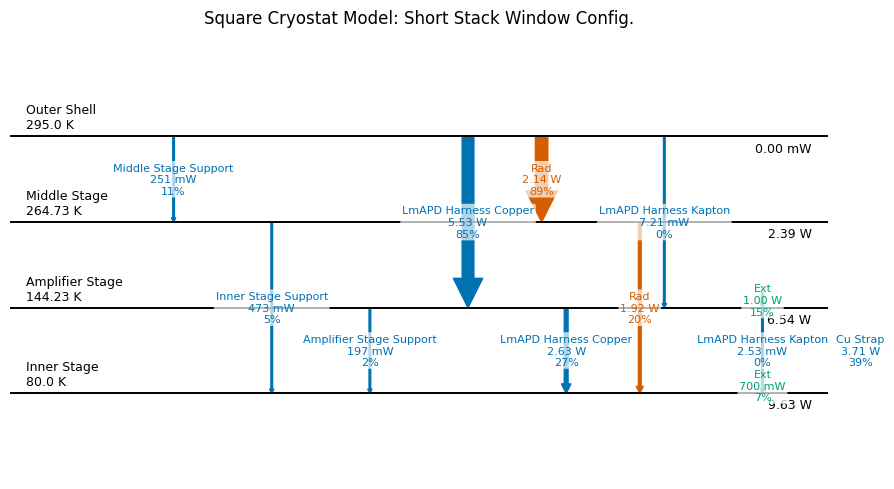

In [2]:

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import astropy.units as u

from cryotherm import DATA_PATH                      # packaged resource
from cryotherm.material_db import MaterialDatabase
from cryotherm.stage import Stage
from cryotherm.conduction import Conduction
from cryotherm.radiation import Radiation
from cryotherm.solver import ThermalModel
from cryotherm.visualize import visualize_model   # or paste the code block once


in_to_m = 0.0254  # conversion factor from inches to metres


# ---------------------------------------------------------------------
# Material DB
# ---------------------------------------------------------------------
db = MaterialDatabase(DATA_PATH)

# list available materials
print("Available materials:")
db.report()



# ---------------------------------------------------------------------
#  Stages
# ---------------------------------------------------------------------
outer_shell_temp = 295  # K
middle_stage_temp = 200  # K
inner_stage_temp = 80  # K
amplifier_stage_temp = 150  # K

outer = Stage("Outer Shell", outer_shell_temp, fixed=True)
middle = Stage("Middle Stage", middle_stage_temp, fixed=False)
use_fridge = False
if use_fridge:
    inner = Stage("Inner Stage", inner_stage_temp, fridge_curve="CryotelGT", fixed=False)
else:
    inner = Stage("Inner Stage", inner_stage_temp, fixed=True, external_load = 0.7)

amplifier_stage = Stage("Amplifier Stage", amplifier_stage_temp, external_load = 1.0, fixed=False,
                        #target_temperature=amplifier_stage_temp,
                        )

# ---------------------------------------------------------------------
#  Conduction
# ---------------------------------------------------------------------
standoff_material = "G10warp"  # material of the support cylinder
# Middle Stage Support
support_angle = 60  # degrees between supports
height_above_base = 1.125*in_to_m # height in metres\
length = height_above_base/np.sin(np.radians(support_angle)) # height in metres
width = 0.5*in_to_m # width in metres
thickness = 0.125*in_to_m # thickness in metres
number = 8  # number of support rods
# set up the support using the geometric methods
middle_stage_mech_support = Conduction(outer, middle, type = "rect", width=width, thickness=thickness,
                                length=length, number=number, 
                                material=standoff_material, mat_db=db, method = "legacy",
                                name="Middle Stage Support")
print(f"Middle Stage Support length = {middle_stage_mech_support.length:.3f} m, Area = {middle_stage_mech_support.area:.3e} m²")


# Inner Stage Support



height_between_stages = 2.625*in_to_m # height in metres


support_angle = 60  # degrees between supports
length = height_between_stages/np.sin(np.radians(support_angle)) # height in metres
print(f"length = {length/in_to_m} in")
width = 0.5*in_to_m # width in metres
thickness = 0.125*in_to_m # thickness in metres
number = 8  # number of support rods
# set up the support using the geometric methods
inner_stage_mech_support = Conduction(middle, inner, type = "rect", width=width, thickness=thickness,
                                length=length, number=number, 
                                material=standoff_material, mat_db=db, method = "legacy",
                                name="Inner Stage Support")

print(f"Inner Stage Support length = {inner_stage_mech_support.length:.3f} m, Area = {inner_stage_mech_support.area:.3e} m²")

# Support for Amplifier Stage
amplifier_stage_height_above_base = 1.0*in_to_m # height in metres\
amplifier_stage_length = amplifier_stage_height_above_base
amplifier_stage_width = 0.5*in_to_m # width in metres
amplifier_stage_thickness = 0.125*in_to_m # thickness in metres
amplifier_stage_number = 4  # number of support rods
# set up the support using the geometric methods
amplifier_stage_mech_support = Conduction(inner, amplifier_stage, type = "rect", 
                                          width=amplifier_stage_width, thickness=amplifier_stage_thickness,
                                          length = amplifier_stage_length, number=amplifier_stage_number, 
                                          material=standoff_material, mat_db=db, method = "legacy",
                                          name="Amplifier Stage Support")

# ---------------------------------------------------------------------
# Radiation
# ---------------------------------------------------------------------

# Radiation: Middle -> Inner
inner_shell_diameter = 8.75*in_to_m # outer diameter in metres
inner_shell_height = 3.0*in_to_m # height in metres
area_plate = inner_shell_diameter**2 / 4 * np.pi  # area of the top plate
area_wall = np.pi * inner_shell_diameter * inner_shell_height  # area of the cylindrical wall
total_surface_area = area_wall + 2*area_plate  # total surface area of the outer shell
emissivity_outer = 0.08
emissivity_inner = 0.08

#radiation_middle_to_inner = Radiation(middle, inner, type = "cylinder", diameter = diameter, height = height, emissivity1=emissivity_outer, emissivity2=emissivity_inner,
#                                      name = None)
radiation_middle_to_inner = Radiation(middle, inner, type = "box", length = inner_shell_diameter, width = inner_shell_diameter, height = inner_shell_height, 
                                      emissivity1=emissivity_outer, emissivity2=emissivity_inner,
                                      name = None)
print("Radiation: Middle -> Inner")
print(f"\tPlate area: {area_plate:.3f} m²")
print(f"\tWall area: {area_wall:.3f} m²")
print(f"\tTotal surface area: {total_surface_area:.3f} m²")
print(f"\tPower: {radiation_middle_to_inner.heat_flow(middle_stage_temp, inner_stage_temp):.2e} W")


# Radiation: Outer -> Middle
middle_shell_diameter = 10.75*in_to_m # outer diameter
middle_shell_height = 6.875*in_to_m # height in metres
print(f"middle_shell_height = {middle_shell_height/in_to_m} in")
area_plate = middle_shell_diameter**2 / 4 * np.pi  # area of the top plate
area_wall = np.pi * middle_shell_diameter * middle_shell_height  # area of the cylindrical wall

total_surface_area = area_wall + 2*area_plate  # total surface area of the outer shell
# Emissivity values for the outer and inner surfaces
emissivity_outer = 0.08
emissivity_inner = 0.08

#radiation_outer_to_middle = Radiation(outer, middle, type = "cylinder", diameter = diameter, 
#                                      height = height, 
#                                      emissivity1=emissivity_outer, emissivity2=emissivity_inner,
#                                      name= None)
radiation_outer_to_middle = Radiation(outer, middle, type = "box", 
                                      length = middle_shell_diameter, width = middle_shell_diameter, height = middle_shell_height, 
                                      emissivity1=emissivity_outer, emissivity2=emissivity_inner,
                                      name= None)
print("Radiation: Outer -> Middle")
print(f"\tPlate area: {area_plate:.3f} m²")
print(f"\tWall area: {area_wall:.3f} m²")
print(f"\tTotal surface area: {total_surface_area:.3f} m²")
print(f"\tPower: {radiation_outer_to_middle.heat_flow(outer_shell_temp, middle_stage_temp):.2e} W")

print(f"Inner Shell: Height = {inner_shell_height/in_to_m} in, Width = {inner_shell_diameter/in_to_m} in")
print(f"Middle Shell: Height = {middle_shell_height/in_to_m} in, Width = {middle_shell_diameter/in_to_m} in")

# ---------------------------------------------------------------------
# IDIOT CHECKS AGAINST EXCEL MODEL
# ---------------------------------------------------------------------
outer_stage_check_temp = 295  # K
middle_stage_check_temp = 252.01 # K
inner_stage_check_temp = 80  # K
print("IDIOT CHECKS:")
print("\tCONDUCTION:")
print(f"\t\tConInt {standoff_material} from {outer_stage_check_temp} -> {middle_stage_check_temp} K: {db.get_integral(standoff_material, T1 = outer_stage_check_temp, T2 = middle_stage_check_temp, method='legacy'):.3f} W/K")
print(f"\t\tConInt {standoff_material} from {middle_stage_check_temp} -> {inner_stage_check_temp} K: {db.get_integral(standoff_material, T1 = middle_stage_check_temp, T2 = inner_stage_check_temp, method='legacy'):.3f} W/K")
print(f"\t\tOuter -> Middle Strap Heat Flow: {outer_stage_check_temp} -> {middle_stage_check_temp} K: {middle_stage_mech_support._strap_heat(outer_stage_check_temp, middle_stage_check_temp):.3f} W/K")
print(f"\t\tMiddle -> Inner Strap Heat Flow: {middle_stage_check_temp} -> {inner_stage_check_temp} K: {inner_stage_mech_support._strap_heat(middle_stage_check_temp, inner_stage_check_temp):.3f} W/K")
print(f"\t\tOuter -> Middle Conduction Total Power: {outer_stage_check_temp} -> {middle_stage_check_temp} K: {middle_stage_mech_support.heat_flow(outer_stage_check_temp, middle_stage_check_temp):.3f} W")
print(f"\t\tMiddle -> Inner Conduction Total Power: {middle_stage_check_temp} -> {inner_stage_check_temp} K: {inner_stage_mech_support.heat_flow(middle_stage_check_temp, inner_stage_check_temp):.3f} W")

print("\tRADIATION:")
print(f"\t\tOuter -> Middle Radiation: Area = {radiation_outer_to_middle.area:.3f} m²")
print(f"\t\tMiddle -> Inner Radiation: Area = {radiation_middle_to_inner.area:.3f} m²")
print(f"\t\tOuter -> Middle Radiation Power: {outer_stage_check_temp} -> {middle_stage_check_temp} K: {radiation_outer_to_middle.heat_flow(outer_stage_check_temp, middle_stage_check_temp):.3f} W")
print(f"\t\tMiddle -> Inner Radiation Power: {middle_stage_check_temp} -> {inner_stage_check_temp} K: {radiation_middle_to_inner.heat_flow(middle_stage_check_temp, inner_stage_check_temp):.3f} W")

print("\tTOTALS")
print(f"\t\tOuter -> Middle Total Power: {middle_stage_mech_support.heat_flow(outer_stage_check_temp, middle_stage_check_temp) + radiation_outer_to_middle.heat_flow(outer_stage_check_temp, middle_stage_check_temp):.3f} W")
print(f"\t\tMiddle -> Inner Total Power: {inner_stage_mech_support.heat_flow(middle_stage_check_temp, inner_stage_check_temp) + radiation_middle_to_inner.heat_flow(middle_stage_check_temp, inner_stage_check_temp):.3f} W")

# ---------------------------------------------------------------------
# WIRING HARNESSES
# ---------------------------------------------------------------------

# 4k x 6k harness
#   dimensions: 100+69 wires, 36 AWG, 0.127 mm dia, manganin
length_harness = 12*in_to_m  # length in metres
number_wires = 169  # number of wires
wire_diameter = 0.127e-3  # diameter in metres
wire_material = "manganin"
harness_4k6k = Conduction(outer, inner, type = "cylinder", diameter=wire_diameter, length=length_harness,
                          number=number_wires, material=wire_material, mat_db=db, method = "legacy",
                          name="4k x 6k Harness")
print(f"4k x 6k Harness length = {harness_4k6k.length:.3f} m, Area = {harness_4k6k.area:.3e} m²")
print(f"\tConInt {wire_material} from {middle_stage_temp} -> {inner_stage_temp} K: {db.get_integral(wire_material, T1 = middle_stage_temp, T2 = inner_stage_temp, method='legacy'):.3f} W/K")
print(f"\t4k x 6k Harness Strap Heat Flow: {middle_stage_temp} -> {inner_stage_temp} K: {harness_4k6k._strap_heat(middle_stage_temp, inner_stage_temp):.3f} W/K")

# LmAPD harness
#   dimensions: 20 wires, 36 AWG, 0.127 mm dia, manganin
lmapd_harness_length = 6*in_to_m  # length in metres
lmapd_harness_layers = 6 # number of layers
lmapd_harness_copper_thickness = 30e-6  # 1 oz copper ~> 30 um thickness of copper layer in metres
lmapd_harness_width = 3 *in_to_m  # width in metres
lmapd_harness_material = "CuRRR100"
harness_lmapd = Conduction(outer, amplifier_stage, type = "rect", 
                           length=lmapd_harness_length, width=lmapd_harness_width,thickness=lmapd_harness_copper_thickness,
                           material = lmapd_harness_material, mat_db = db, number=lmapd_harness_layers, method = "legacy",
                           name = "LmAPD Harness Copper")

#harness from amplifier stage to LmAPD
harness_lmapd_fpa = Conduction(amplifier_stage, inner, type = "rect", 
                           length=lmapd_harness_length, width=lmapd_harness_width,thickness=lmapd_harness_copper_thickness,
                           material = lmapd_harness_material, mat_db = db, number=lmapd_harness_layers, method = "legacy",
                           name = "LmAPD Harness Copper")


lmapd_harness_kapton = Conduction(outer, amplifier_stage, type = "rect", 
                           length=lmapd_harness_length, 
                           width=lmapd_harness_width,
                           thickness=7.62e-5,# 3 mil kapton thickness
                           material = "Kapton", 
                           mat_db = db, 
                           number=int(lmapd_harness_layers+1), 
                           method = "legacy",
                           name = "LmAPD Harness Kapton")

lmapd_harness_kapton_fpa = Conduction(amplifier_stage, inner, type = "rect", 
                           length=lmapd_harness_length, 
                           width=lmapd_harness_width,
                           thickness=7.62e-5,# 3 mil kapton thickness
                           material = "Kapton", 
                           mat_db = db, 
                           number=int(lmapd_harness_layers+1), 
                           method = "legacy",
                           name = "LmAPD Harness Kapton")

loose_heat_strap_amp_to_inner = Conduction(amplifier_stage, inner, type = "rect", 
                                           thickness=0.02*in_to_m, length=4*in_to_m, width=1*in_to_m,
                                            number=1, material="CuRRR100", mat_db=db, method = "legacy",
                                            name = "Cu Strap")

loose_heat_strap_middle_to_amp = Conduction(middle, amplifier_stage, type = "rect", 
                                           thickness=0.02*in_to_m, length=4*in_to_m, width=0.5*in_to_m,
                                            number=1, material="CuRRR100", mat_db=db, method = "legacy",
                                            name = "Cu Strap")


# ---------------------------------------------------------------------
#  Solve
# ---------------------------------------------------------------------
model = ThermalModel(
    stages=[outer, middle, inner,
            amplifier_stage,
            ],
    conductors=[
        middle_stage_mech_support, 
        inner_stage_mech_support, 
        amplifier_stage_mech_support,
        #harness_4k6k,
        harness_lmapd,
        harness_lmapd_fpa,
        lmapd_harness_kapton,
        lmapd_harness_kapton_fpa,
        loose_heat_strap_amp_to_inner,
        #loose_heat_strap_middle_to_amp,
        ],
    radiators=[radiation_outer_to_middle, radiation_middle_to_inner],
)

model.solve()                     # raises if the optimizer fails

for s in model.stages:
    print(f"{s.name:15s}:  {s.temperature:6.2f} K   netQ={s.net_heat_flow:+8.4f} W")

visualize_model(model, scale = 50, title = "Square Cryostat Model: Short Stack Window Config.")

model.report()
